## Unsupervised Learning Capstone
>

In [35]:
import numpy as np
import pandas as pd
import scipy
import math
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from datetime import datetime as dt
from collections import Counter
import re
import spacy
import nltk
from nltk.corpus import gutenberg, stopwords
from nltk.corpus import brown, crubadan, timit

import sklearn
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# clustering models
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering

In [2]:
# utility function
def text_cleaner(x):
    """Removing certain chars by using regular expressions."""
    x = re.sub(r'--', ' ', x)
    x = re.sub(r'\*+', ' ', x)
    x = re.sub("[\[].*?[\]]", "", x)
    x = ' '.join(x.split())
    return x

In [3]:
def record_start_time(t = dt.now):
    """A system timer for start time."""
    print('start time {}'.format(t))
    return t

In [4]:
def record_end_time(starttime, t = dt.now):
    """A system timer for end time."""
    print('end time {}'.format(t))
    print('Total time passed is {}'.format(t - starttime))
    return t

In [5]:
def word_frequencies(x, include_stop=True):
    """Generate word counts for a string."""
    words = []
    for token in x:
        if not token.is_punct and (not token.is_stop or include_stop):
            words.append(token.text)
            
    return Counter(words)

In [6]:
def lemma_frequencies(text, include_stop=True):
    """Generate word lemma counts for a string"""
    lemmas = []
    for token in text:
        if not token.is_punct and (not token.is_stop or include_stop):
            lemmas.append(token.lemma_)
    
    return Counter(lemmas)

In [7]:
def bag_of_words(text, nsize, include_stop):
    """Generate list of words contained in a string."""
    container = lemma_frequencies(text, include_stop).most_common(nsize)
    return [item[0] for item in container]  

In [23]:
def bow_of_features(sentences, common_words):
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    for i, sentence in enumerate(df['text_sentence']):
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
    
        for word in words:
            df.loc[i, word] += 1
        
        if i % 1000 == 0:
            print('Processing row {}'.format(i))
    
    return df

In [25]:
def stat_words_per_sentence(sentences, df):
    words = []
    for ss in sentences[0]:
        words.append(len(ss)) 
        
    df_local = pd.DataFrame(words, columns=['entity'])
    df['count'] = df_local.describe().loc['count', 'entity']
    df['25perc'] = df_local.describe().loc['25%', 'entity']
    df['50perc'] = df_local.describe().loc['50%', 'entity']
    df['75perc'] = df_local.describe().loc['75%', 'entity']
    df['max'] = df_local.describe().loc['max', 'entity']

In [9]:
#print(brown.fileids())
print(gutenberg.fileids())

austen1 = gutenberg.raw('austen-' + 'emma' + '.txt')
austen2 = gutenberg.raw('austen-' + 'persuasion' + '.txt')
bryant = gutenberg.raw('bryant-' + 'stories' + '.txt')
burgess = gutenberg.raw('burgess-busterbrown' + '.txt')
carroll = gutenberg.raw('carroll-alice' + '.txt')
chesterton = gutenberg.raw('chesterton-brown' + '.txt')
edgeworth = gutenberg.raw('edgeworth-parents' + '.txt')
melville = gutenberg.raw('melville-moby_dick' + '.txt')
milton = gutenberg.raw('milton-paradise' + '.txt')
shakespeare = gutenberg.raw('shakespeare-caesar' + '.txt')
whitman = gutenberg.raw('whitman-leaves' + '.txt')

print('DONE')

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']
DONE


In [10]:
# cleanup dataset
# remove VOLUME, CHAPTER
austen1 = re.sub(r'CHAPTER [I]*[V]*[X]*', '', austen1)
austen1 = re.sub(r'VOLUME [I]*[V]*[X]*', '', austen1)
austen1 = text_cleaner(austen1)
                 
austen2 = re.sub(r'Chapter \d+', '', austen2)
austen2 = text_cleaner(austen2)
                 
bryant = text_cleaner(bryant)
                 
burgess = re.sub(r'[I]*[V]*[X]*\n', '', burgess)
burgess = text_cleaner(burgess)

#carroll = re.sub[r'CHAPTER [A-Z]*.', '', carroll]
carroll = text_cleaner(carroll)                
                 
chesterton = text_cleaner(chesterton)

edgeworth = text_cleaner(edgeworth)
                 
milton = text_cleaner(milton)

shakespeare = text_cleaner(shakespeare)

whitman = text_cleaner(whitman)

In [11]:
# feature engineer
nlp = spacy.load('en_core_web_sm')
austen1_doc = nlp(austen1)
austen2_doc = nlp(austen2)
bryant_doc = nlp(bryant)
burgess_doc = nlp(burgess)
carroll_doc = nlp(carroll)
chesterton_doc = nlp(chesterton)
edgeworth_doc = nlp(edgeworth)
milton_doc = nlp(milton)
shakespeare_doc = nlp(shakespeare)
whitman_doc = nlp(whitman)
print('DONE')

DONE


In [49]:
# group into sentences
austen1_sents = [[sent, 0] for sent in austen1_doc.sents]                       # austen1 ---  0
austen2_sents = [[sent, 1] for sent in austen2_doc.sents]                       # austen2 ---  1
bryant_sents = [[sent, 2] for sent in bryant_doc.sents]                         # bryant  ---  2
burgess_sents = [[sent, 3] for sent in burgess_doc.sents]                       # burgess ---  3
carroll_sents = [[sent, 4] for sent in carroll_doc.sents]                       # carroll ---  4
chesterton_sents = [[sent, 5] for sent in chesterton_doc.sents]                 # chesterton ---  5
edgeworth_sents = [[sent, 6] for sent in edgeworth_doc.sents]                   # edgeworth ---6
milton_sents = [[sent, 7] for sent in milton_doc.sents]                         # milton  ---  7    
shakespeare_sents = [[sent, 8] for sent in shakespeare_doc.sents]               # shakespeare --- 8
whitman_sents = [[sent, 9] for sent in whitman_doc.sents]                       # whitman ---  9

sentences = pd.DataFrame(austen1_sents +
                         austen2_sents +
                         bryant_sents +
                         burgess_sents +
                         carroll_sents +
                         chesterton_sents +
                         edgeworth_sents +
                         milton_sents +
                         shakespeare_sents +
                         whitman_sents)
sentences.head()

,0,1
0,"(Emma, Woodhouse, ,, handsome, ,, clever, ,, a...",0
1,"(She, was, the, youngest, of, the, two, daught...",0
2,"(Her, mother, had, died, too, long, ago, for, ...",0
3,"(Sixteen, years, had, Miss, Taylor, been, in, ...",0
4,"(Between, _, them)",0


In [50]:
# constructing bag_of_words
austen1_common = bag_of_words(austen1_doc, 20, False)        
austen2_common = bag_of_words(austen2_doc, 20, False)
bryant_common = bag_of_words(bryant_doc, 20, False)
burgess_common = bag_of_words(burgess_doc, 20, False)
carroll_common = bag_of_words(carroll_doc, 20, False)
chesterton_common = bag_of_words(chesterton_doc, 20, False)
edgeworth_common = bag_of_words(edgeworth_doc, 20, False)
milton_common = bag_of_words(milton_doc, 20, False)
shakespeare_common = bag_of_words(shakespeare_doc, 20, False)
whitman_common = bag_of_words(whitman_doc, 20, False)

# common and unique words
words_common = [x for x in (set(austen1_common) - set(austen2_common) - set(bryant_common) - set(burgess_common) -
                            set(carroll_common) - set(chesterton_common) - set(edgeworth_common) - set(milton_common) -
                            set(shakespeare_common) - set(whitman_common))]

for y in (set(austen2_common) - set(austen1_common) - set(bryant_common) - set(burgess_common) - set(carroll_common) - 
          set(chesterton_common) - set(edgeworth_common) - set(milton_common) - set(shakespeare_common) - set(whitman_common)):
    words_common.append(y)
    
for y in (set(bryant_common) - set(austen1_common) - set(austen2_common) - set(burgess_common) - set(carroll_common) - 
          set(chesterton_common) - set(edgeworth_common) - set(milton_common) - set(shakespeare_common) - set(whitman_common)):
    words_common.append(y)
    
for y in (set(burgess_common) - set(austen1_common) - set(bryant_common) - set(austen2_common) - set(carroll_common) - 
          set(chesterton_common) - set(edgeworth_common) - set(milton_common) - set(shakespeare_common) - set(whitman_common)):
    words_common.append(y)
    
for y in (set(carroll_common) - set(austen1_common) - set(bryant_common) - set(burgess_common) - set(austen2_common) - 
          set(chesterton_common) - set(edgeworth_common) - set(milton_common) - set(shakespeare_common) - set(whitman_common)):
    words_common.append(y)
    
for y in (set(chesterton_common) - set(austen1_common) - set(bryant_common) - set(burgess_common) - set(carroll_common) - 
          set(austen2_common) - set(edgeworth_common) - set(milton_common) - set(shakespeare_common) - set(whitman_common)):
    words_common.append(y)
    
for y in (set(edgeworth_common) - set(austen1_common) - set(bryant_common) - set(burgess_common) - set(carroll_common) - 
          set(chesterton_common) - set(austen2_common) - set(milton_common) - set(shakespeare_common) - set(whitman_common)):
    words_common.append(y)
    
for y in (set(milton_common) - set(austen1_common) - set(bryant_common) - set(burgess_common) - set(carroll_common) - 
          set(chesterton_common) - set(edgeworth_common) - set(austen2_common) - set(shakespeare_common) - set(whitman_common)):
    words_common.append(y)
    
for y in (set(shakespeare_common) - set(austen1_common) - set(bryant_common) - set(burgess_common) - set(carroll_common) - 
          set(chesterton_common) - set(edgeworth_common) - set(milton_common) - set(austen2_common) - set(whitman_common)):
    words_common.append(y)
    
for y in (set(whitman_common) - set(austen1_common) - set(bryant_common) - set(burgess_common) - set(carroll_common) - 
          set(chesterton_common) - set(edgeworth_common) - set(milton_common) - set(shakespeare_common) - set(austen2_common)):
    words_common.append(y)


In [51]:
# constructing Dataset
features = bow_of_features(sentences, words_common)
# add words per sentence statistics
stat_words_per_sentence(sentences, features)

Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Processing row 4000
Processing row 5000
Processing row 6000
Processing row 7000
Processing row 8000
Processing row 9000
Processing row 10000
Processing row 11000
Processing row 12000
Processing row 13000
Processing row 14000
Processing row 15000
Processing row 16000
Processing row 17000
Processing row 18000
Processing row 19000
Processing row 20000
Processing row 21000
Processing row 22000
Processing row 23000
Processing row 24000
Processing row 25000
Processing row 26000
Processing row 27000
Processing row 28000
Processing row 29000
Processing row 30000
Processing row 31000
Processing row 32000
Processing row 33000
Processing row 34000
Processing row 35000
Processing row 36000
Processing row 37000
Processing row 38000
Processing row 39000
Processing row 40000
Processing row 41000
Processing row 42000


## Now start with clustering model

In [52]:
# start clustering models
Y = features['text_source']
X = features.drop(['text_source', 'text_sentence'], 1)

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.75, random_state=42)

Comparing k-means and mini batch k-means solutions: 
text_source     0     1     2    3     4     5     6     7     8     9
row_0                                                                 
0             454   112     1    0     5    32   169     4     0     5
1            6969  3009  2387  863  1510  3082  8500  1963  2057  4865
2             201   106    69   27    48    96   301    64     9   143
3             130    83    50   19    31    82   116    70     6   180
4             155    96    65    0     5   205   231    44     1    31
5              10     5    14   14    12     6    14   454    17    88
6             150    58    54   27    37    92   288    21    40    51
7             111    48    21    2     2     6    86    74     0   241
8             182   132   104   48    28   115   238    69    14   105
9             561     0     0    1     0     0   224     0     0     0


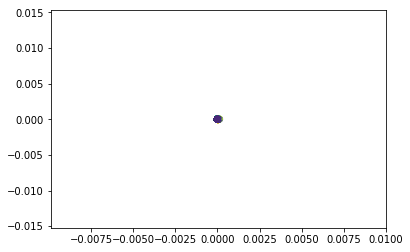

In [53]:
# KMeans cluster model
X_norm = normalize(X)
X_pca = PCA(10).fit_transform(X_norm)
Y_pred = KMeans(n_clusters=10, random_state=42).fit_predict(X_pca)

plt.scatter(X_pca[:,0], X_pca[:,1], c=Y_pred)

# Check the prediction against the data
print('Comparing k-means and mini batch k-means solutions: ')
print(pd.crosstab(Y_pred, Y))

## Looks like the KMeans model don't do very well

In [54]:
# use miniBatch
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=10,
    batch_size=300)
minibatchkmeans.fit(X_pca)
pred_mini = minibatchkmeans.predict(X_pca)

# Check the prediction against the previous solution
print('Comparing k-means and mini batch k-means solutions: ')
print(pd.crosstab(pred_mini, Y_pred))

Comparing k-means and mini batch k-means solutions: 
col_0    0      1    2    3    4    5    6    7    8    9
row_0                                                    
0        0     21  892    0    0    0  722    4    0    0
1        7      0   28  766    1    4   20    9   26    0
2        2    131   17    0    0  628    8   92   14    0
3      729    592   83    0    0    1   18   32  956    0
4        0   2240    0    0    0    0    0    0    0    0
5       36      0   21    0    0    0   18    3    9  784
6        7      0   23    1  832    1   32    7   30    0
7        0  28979    0    0    0    0    0    0    0    0
8        1   1509    0    0    0    0    0    0    0    2
9        0   1733    0    0    0    0    0  444    0    0


In [55]:
print('Comparing mini batch k-means solutions and data: ')
print(pd.crosstab(pred_mini, Y))

Comparing mini batch k-means solutions and data: 
text_source     0     1     2    3     4     5     6     7     8     9
row_0                                                                 
0             292   141   115   54    78   166   514    58    49   172
1             146    97    54   19    35    95   130    76     6   203
2              13     7    21   16    14     8    19   606    18   170
3             615   240   111   49    37   137   440   125    82   575
4             185   123   242   25   107   151   262   563    92   490
5             606     0     0    1     0     0   264     0     0     0
6             173   112    73    0     5   224   263    47     2    34
7            5258  2251  2004  675  1347  2845  7828  1180  1842  3749
8            1124   158    43   11    37    36    67    19     5    12
9             511   520   102  151    18    54   380    89    48   304


In [56]:
# use MeanShift model
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=300)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

labels = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters_ = len(np.unique(labels))
print("Number of estimated clusters : {}".format(n_clusters_))


Number of estimated clusters : 958


## model

In [61]:
rfr = ensemble.RandomForestRegressor()
rfr.fit(X_train, Y_train)

print('Training set score : {}'.format(rfr.score(X_train, Y_train)))
cross_val_score(rfr, X_train, Y_train, cv=5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score : 0.24770749309346918


array([0.20400486, 0.20804485, 0.20679085, 0.19965974, 0.21713367])

In [62]:
# Now take it to test dataset
print('Testing set score : {}'.format(rfr.score(X_test, Y_test)))

Testing set score : 0.20963985578656152


In [ ]:
print('Test set score : {}'.format(rfr.score(X_test, Y_test)))